<a href="https://colab.research.google.com/github/Sinamhd9/Computer-vision-projects/blob/main/transfer%20learning/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning

In this programming excersie, we train a model using transfer learning and convolutional neural networks to perform image classification on cat and dog dataset.

First, we import required libraries

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras import models
import zipfile
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
from tensorflow.math import confusion_matrix
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

We can download the dataset from the link below (I uploaded the data into my google drive)

In [ ]:
#For colab
!gdown --id 1tXo2uBJg1RdeA9Ep3wwIqdCDseZ3rg1x

Downloading...
From: https://drive.google.com/uc?id=1tXo2uBJg1RdeA9Ep3wwIqdCDseZ3rg1x
To: /content/cats_dogs_dataset.zip
100% 456M/456M [00:03<00:00, 132MB/s]


Now, we unzip the dataset 

In [ ]:
# For colab
with zipfile.ZipFile('/content/cats_dogs_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

Next, we download the InceptionResNetV2 with ImageNet weights. Include top is set to false to remove the last layer. 

In [ ]:
pre_model = InceptionResNetV2(weights= "imagenet", include_top =False, input_shape=(150, 150, 3))

219070464/219055592 [==============================] - 3s 0us/step


Here the pretrained model summary is shown, we can see it has 54 million parameters. 

In [ ]:
pre_model.summary()

## Filter visualization

In order to visualize the filters of the first conv layer, we find the layer by name ('conv2d'). The weights of the layer are the learned filters. As we can see the shape is (3,3,3,32) which means there are 32 filter of 3x3, each of which has 3 channels. As there are only 3 channels, we can treat it as RGB for visualization purposes. Therefore we would get 32 color 3x3 images. For other layers, for example, 'conv2d_1' which is the second conv layer, the shape is (3,3,32,32) which means each of the 32, 3x3 filters have also 32 channels. In this case, each of the 32 channels can be visualized in gray scale which results in 32 * 32 visualizations (32 for number of filters, and 32 for each channel). Hopefully, in the first layer, we only have 3 channels and we can visualize it in RGB color space. It should be noted that the weights have arbitrary ranges, and normalizing them to be in range of 0 and 1 is necessary.

filter shape: (3, 3, 3, 32)


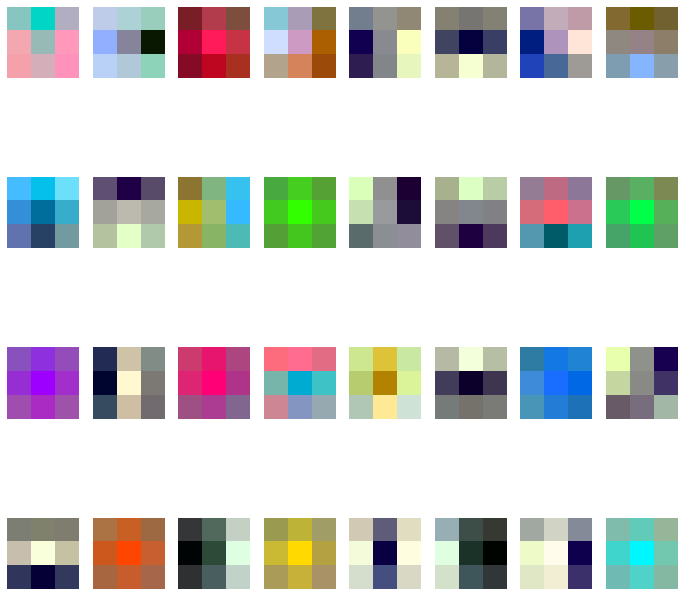

In [ ]:
for layer in pre_model.layers:
    if layer.name=='conv2d':
      filters = layer.get_weights()[0]

print('filter shape:', filters.shape)

fig=plt.figure(figsize=(12, 12))
columns = 8
rows = 4
for i in range(1, columns*rows+1):
    img = filters[:,:,:,i-1]
    img = (img - img.min()) / (img.max() - img.min())
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img)

plt.show()        



We can see that some simple features are obtained. For example, in some, we can see a bright center while corner pixels are dark. In some other, we can see a bright/dark rows and columns which are like horizontal and vertical feature detectors. 

## Image preprocessing

We use data generators to read the images from the source folders and feed them to our model. There is a generator for the training images and one for the testing images. We set the batch size parameter to 32 with the size of 150 and class label of binary.

We normalize the pixel values to be in the range of [0, 1]. In addition, we use some data augmentation techniques like horizontal flipping, zoom, and rotation on the training batches.

In [ ]:
img_size= 150
batch_size = 32


# For colab
train_dir = '/content/dataset/training_set'
test_dir = '/content/dataset/test_set'

train_datagen = ImageDataGenerator(
        rescale =1./255,
        horizontal_flip = True,
        rotation_range = 30,
        zoom_range=0.15,
        fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        directory=train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary') 

test_generator = test_datagen.flow_from_directory(
        directory=test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary', shuffle=False)


Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Here we visualize some images in the training batches. We can see the effect of the augmentation on the images. 

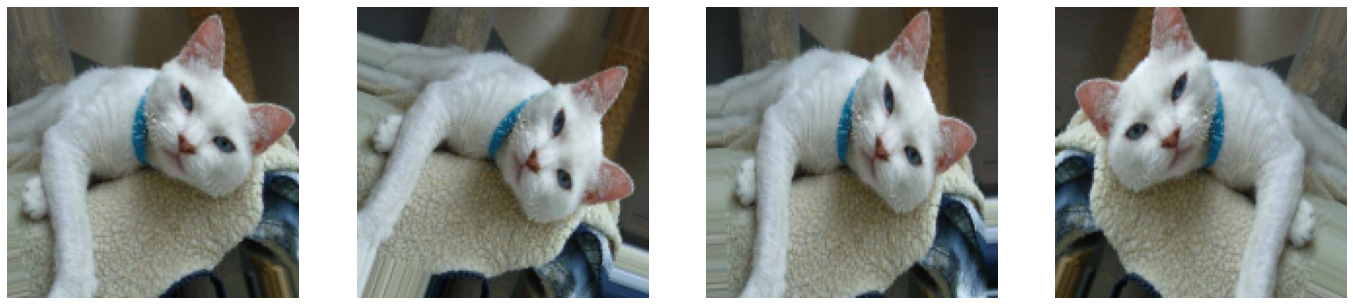

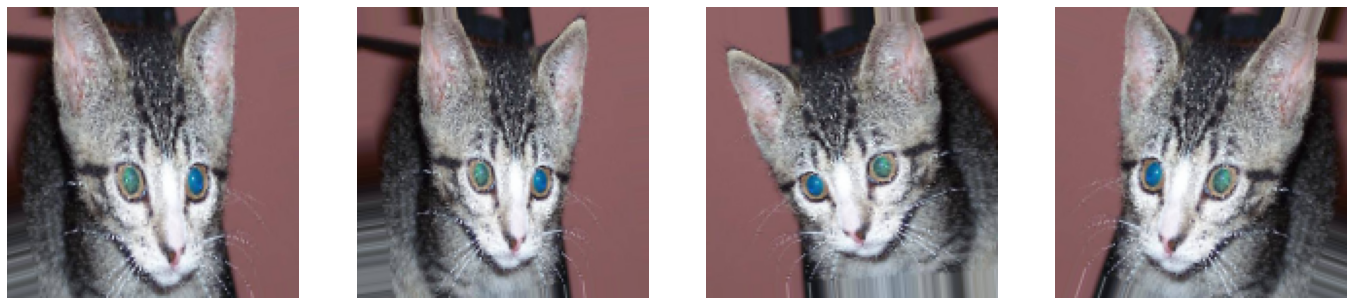

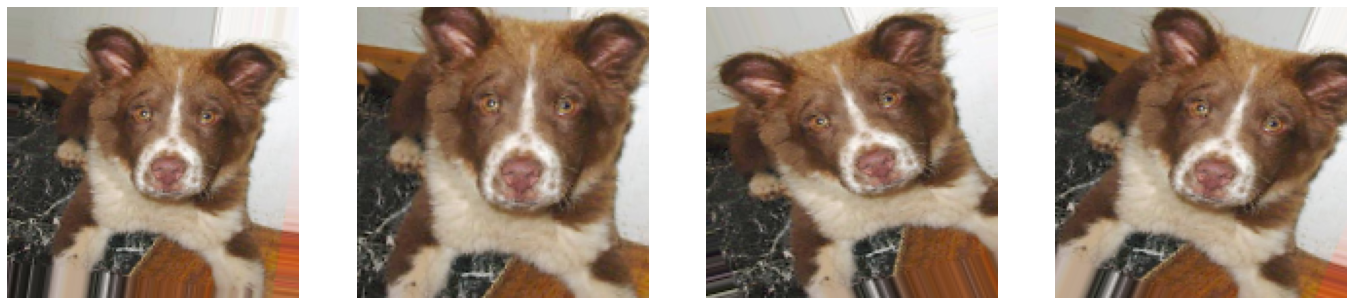

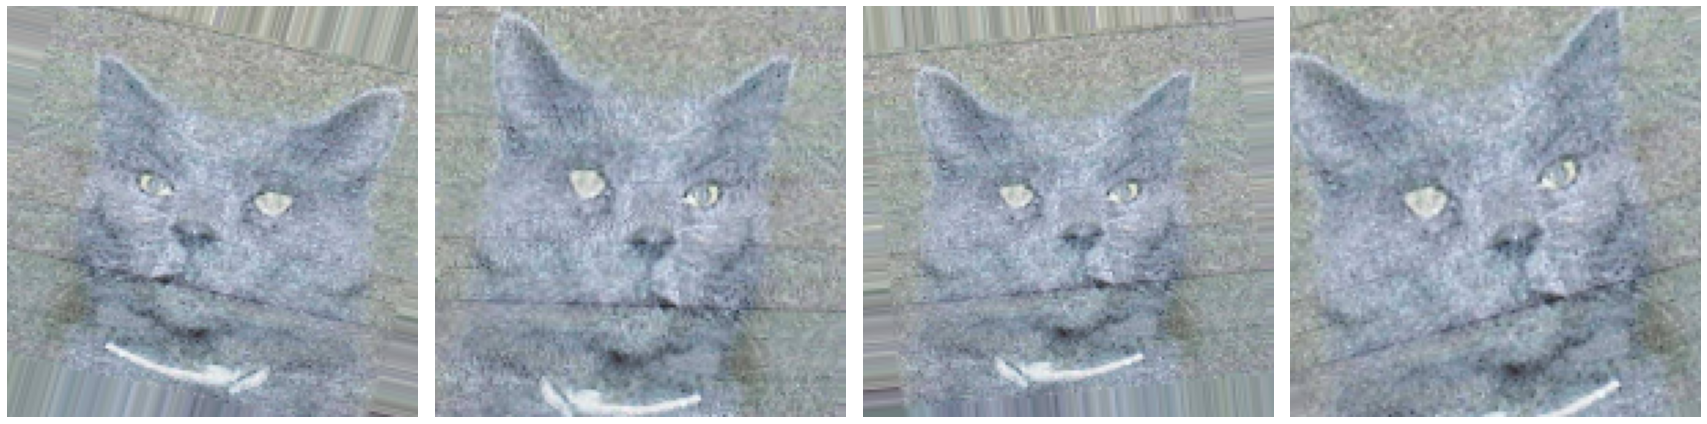

In [ ]:
for j in range(4):
    aug_images = [train_generator[0][0][j] for i in range(4)]
    fig, axes = plt.subplots(1, 4, figsize=(24,24))
    axes = axes.flatten()
    for img, ax in zip(aug_images, axes):
        ax.imshow(img)
        ax.axis('off')
plt.tight_layout()
plt.show()

## Defining the transfer head and the new model

In [ ]:
model = models.Sequential()
model.add(pre_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
pre_model.trainable=False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               3539200   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 57,876,193
Trainable params: 3,539,457
Non-trainable params: 54,336,736
_________________________________________________________________


As we can see the pretrained layer is frozen and the trainable parameters are only 3.5 million.

## Model evaluation without training

Before training, we test the accuracy of the model on the dataset

In [ ]:
preds = np.round(model.predict(test_generator))
actual = test_generator.labels

In [ ]:
cfmx = confusion_matrix(actual, preds, num_classes=2)
acc = accuracy_score(actual, preds)
print ('Accuracy:', acc )
print('Confusion matrix:', cfmx)

Accuracy: 0.501
Confusion matrix: tf.Tensor(
[[988  12]
 [986  14]], shape=(2, 2), dtype=int32)


We can see the accuracy is like a random guess (around 50%). This is because the layers attached to the pretrained model are not trained yet, and the parameters required to find the correct classification are not learned yet.

## Model training

Now we compile and train the model. We use a regular adam optimizer with the default learning rate of 0.001 for the beginning and use `ReduceLROnPlateau` callback to reduce learning rate every 2 epochs if the validation accuracy is not improved. The loss is binary crossentropy as there are only two classes, the metric is accuracy. Max epochs is set to 25 with early stopping to stop the training if validation accuracy is not improved in 5 epochs. 

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')

In [ ]:
rlr = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, patience = 2, verbose = 2, 
                                min_delta = 1e-4, min_lr = 1e-6, mode = 'max')
es = EarlyStopping(monitor = 'val_acc', min_delta = 1e-4, patience = 5, mode = 'max', 
                    restore_best_weights = True, verbose = 2)

history = model.fit(
      train_generator,
      epochs=25,
      validation_data=test_generator,
      callbacks=[es,rlr],
      verbose=1)

Epoch 1/25
250/250 [==============================] - 106s 376ms/step - loss: 0.6524 - acc: 0.9291 - val_loss: 0.0741 - val_acc: 0.9740
Epoch 2/25
250/250 [==============================] - 92s 367ms/step - loss: 0.1057 - acc: 0.9561 - val_loss: 0.0697 - val_acc: 0.9775
Epoch 3/25
250/250 [==============================] - 90s 361ms/step - loss: 0.1000 - acc: 0.9600 - val_loss: 0.0737 - val_acc: 0.9690
Epoch 4/25
250/250 [==============================] - 92s 368ms/step - loss: 0.0884 - acc: 0.9659 - val_loss: 0.0803 - val_acc: 0.9685

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/25
250/250 [==============================] - 94s 375ms/step - loss: 0.0750 - acc: 0.9696 - val_loss: 0.0635 - val_acc: 0.9750
Epoch 6/25
250/250 [==============================] - 94s 377ms/step - loss: 0.0773 - acc: 0.9694 - val_loss: 0.0595 - val_acc: 0.9750

Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 7/25
250/250 [=====

Below, we can see the testing accuracy and confusion matrix. In addition, the training and testing loss and accuracy are shown in the plot. 

In [ ]:
preds = np.round(model.predict(test_generator))
cfmx = confusion_matrix(actual, preds, num_classes=2)
acc = accuracy_score(actual, preds)
print ('Test Accuracy:', acc )
print('Confusion matrix:', cfmx)

Test Accuracy: 0.9775
Confusion matrix: tf.Tensor(
[[981  19]
 [ 26 974]], shape=(2, 2), dtype=int32)


We see that the accuracy on the test set is 0.9775 (**weights are restored to the best epoch**) with low amount of false positives and negatives. 

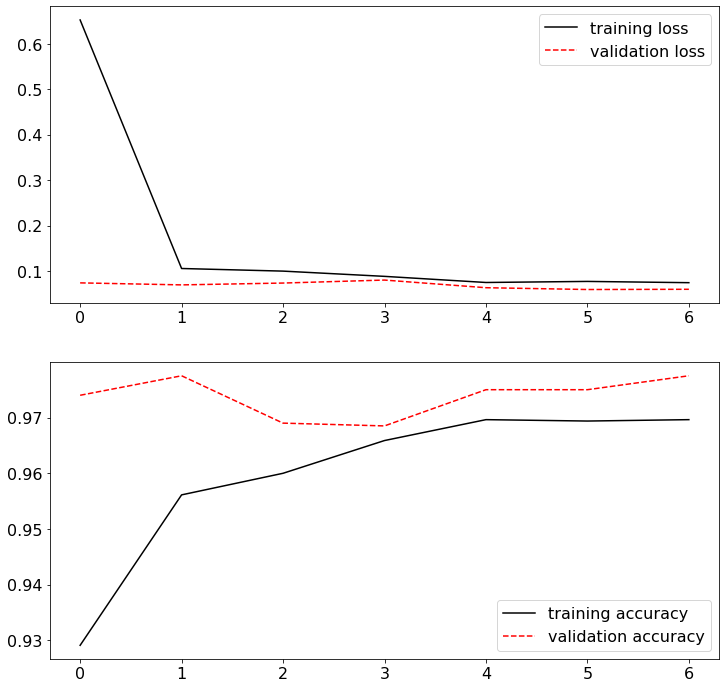

In [ ]:
hist = pd.DataFrame(history.history)
fig, (ax1, ax2) = plt.subplots(figsize=(12,12),nrows=2, ncols=1)
hist['loss'].plot(ax=ax1,c='k',label='training loss')
hist['val_loss'].plot(ax=ax1,c='r',linestyle='--', label='validation loss')
ax1.legend()
hist['acc'].plot(ax=ax2,c='k',label='training accuracy')
hist['val_acc'].plot(ax=ax2,c='r',linestyle='--',label='validation accuracy')
ax2.legend()
plt.show()

## Sub-network training

To understand the pre_model's architecture bettter, we show the whole 
architecture below

In [ ]:
plot_model(pre_model, show_shapes=False, to_file='pre_model.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.591003 to fit



We see it is a huge network. We would like to cut the network at layer 40 (it's the end of first chunk of layers)

In [ ]:
sub_pre_model = models.Model(pre_model.input, pre_model.layers[40].output)

In [ ]:
sub_pre_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

Let's see how it looks like

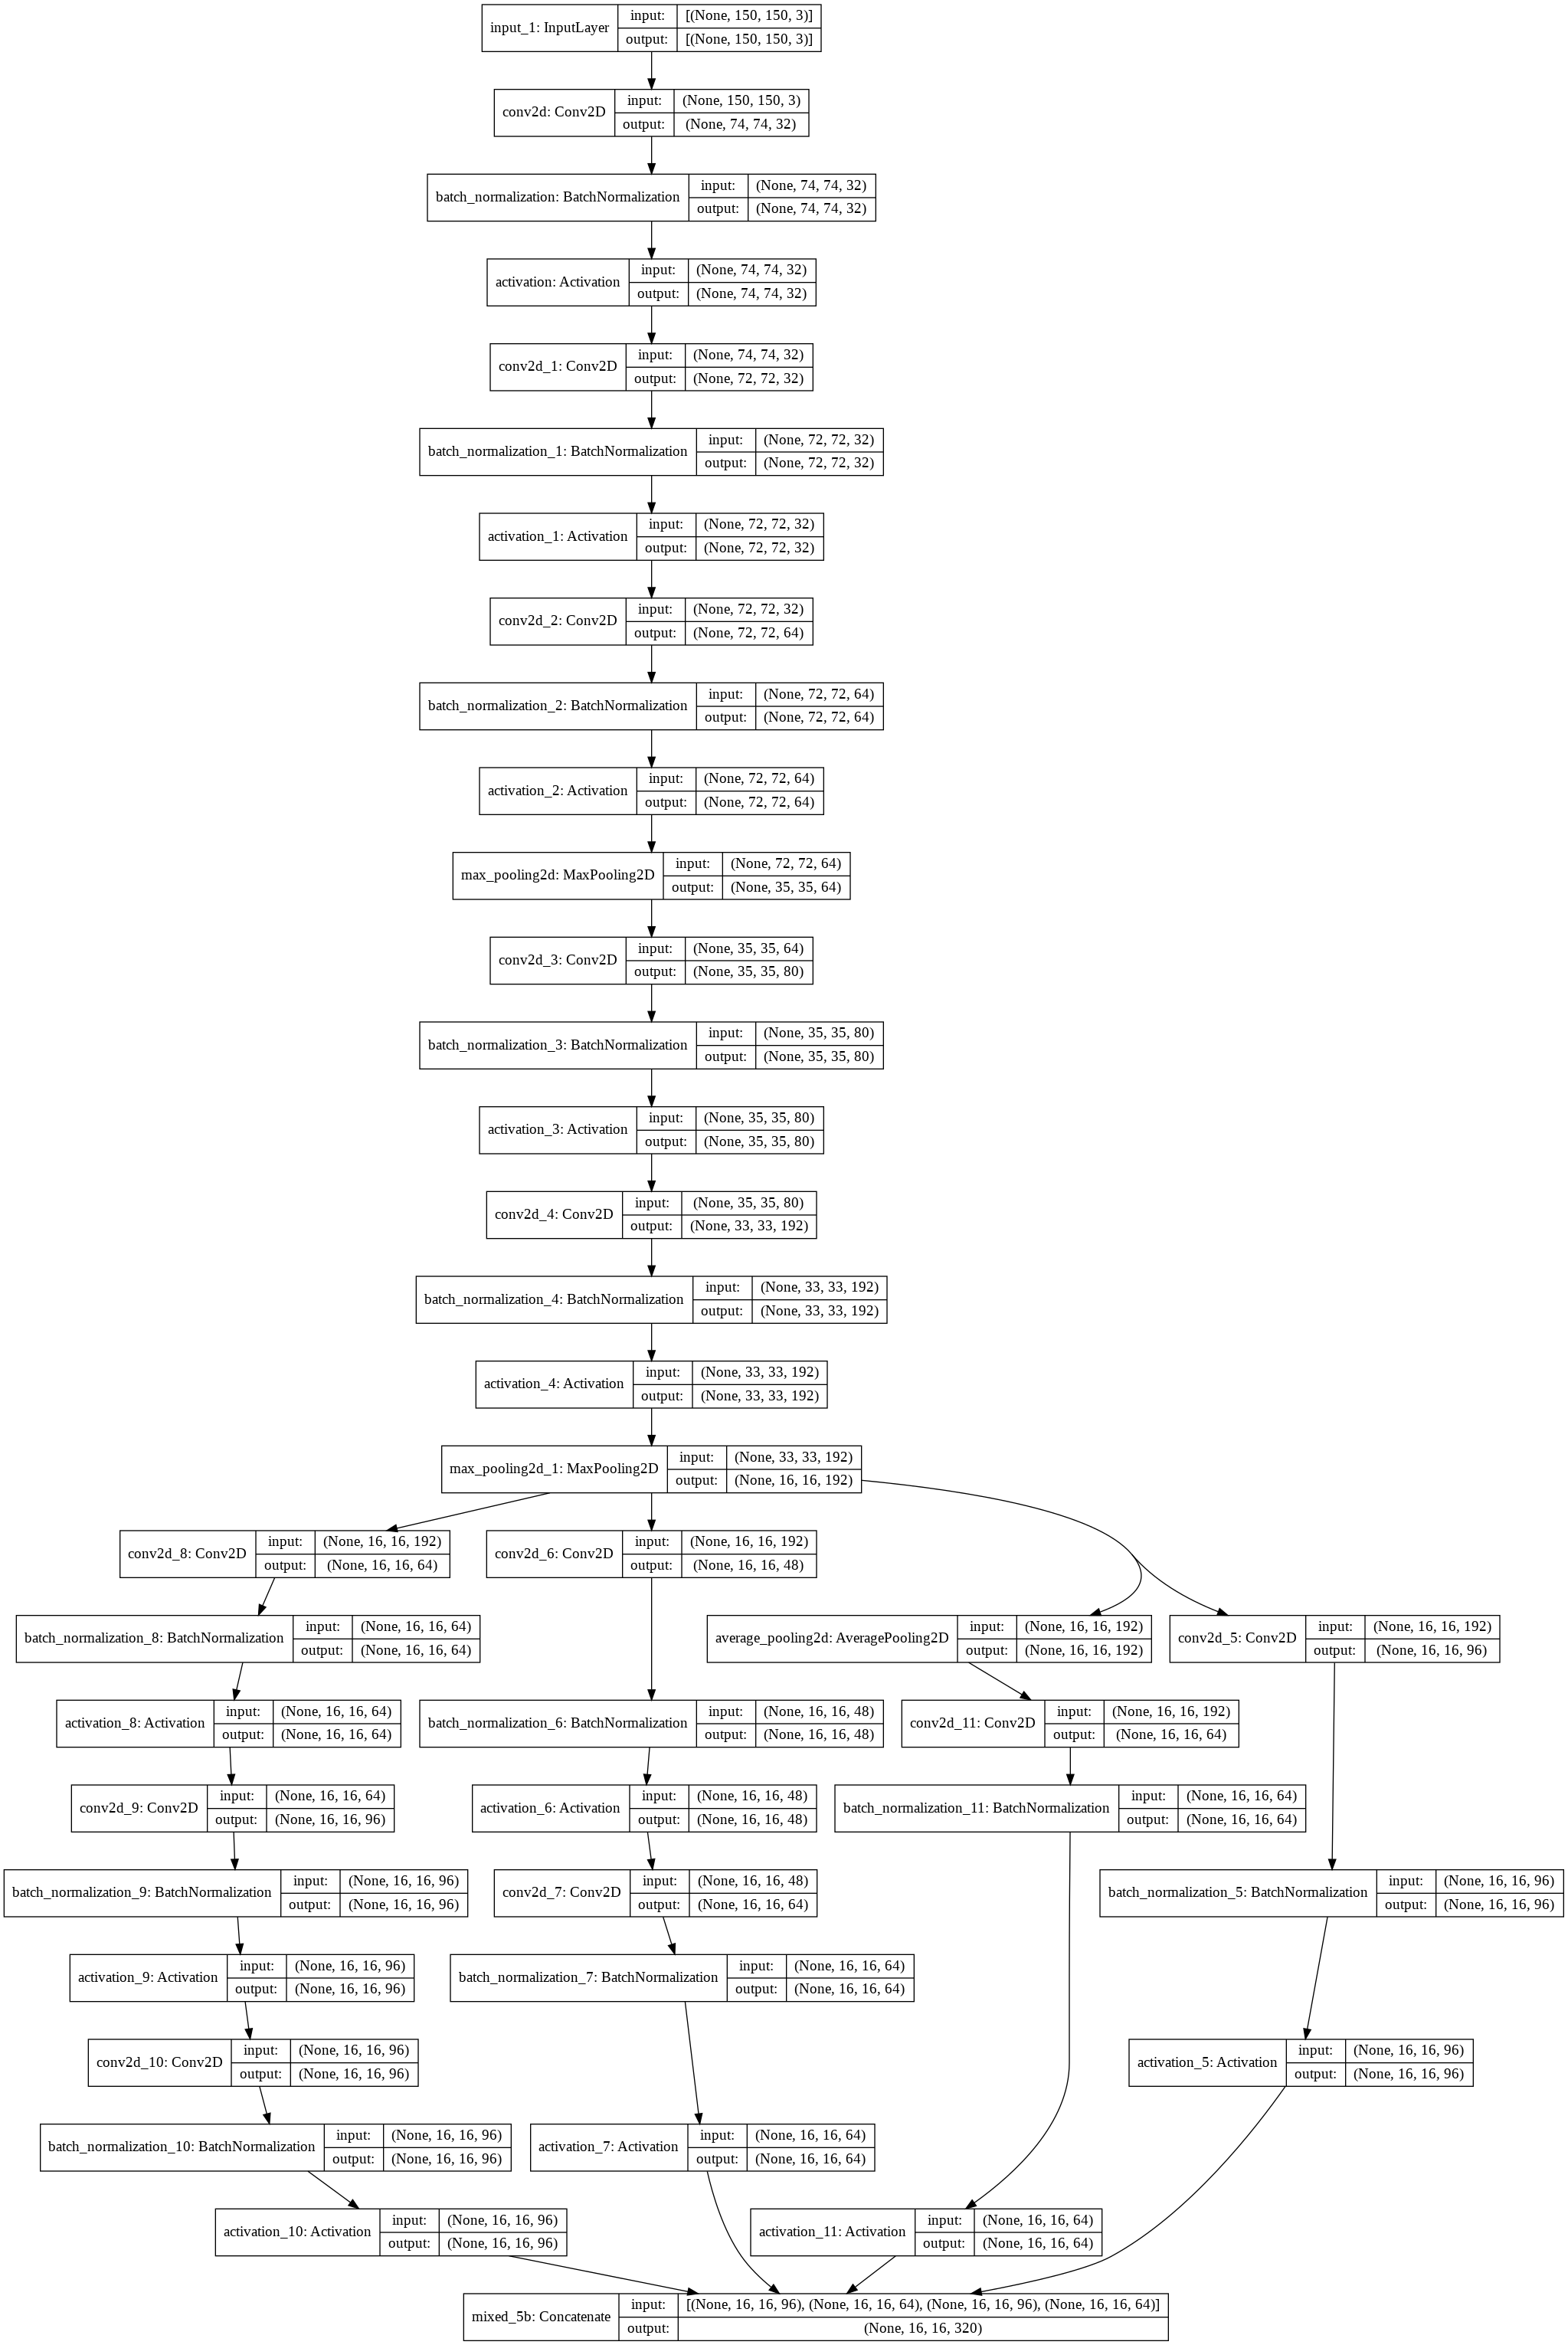

In [ ]:
plot_model(sub_pre_model, show_shapes=True, to_file='sub_pre_model.png')

Now we add the transfer head and freeze the layers of the pretrained sub network

In [ ]:
sub_model = models.Sequential()
sub_model.add(sub_pre_model)
sub_model.add(layers.Flatten())
sub_model.add(layers.Dense(256, activation='relu'))
sub_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
sub_pre_model.trainable=False
sub_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 16, 16, 320)       441920    
_________________________________________________________________
flatten_1 (Flatten)          (None, 81920)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               20971776  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 21,413,953
Trainable params: 20,972,033
Non-trainable params: 441,920
_________________________________________________________________


We train the model using the exact same setup

In [ ]:
sub_model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')

In [ ]:
history2 = sub_model.fit(
      train_generator,
      epochs=25,
      validation_data=test_generator,
      callbacks=[es,rlr],
      verbose=1)

Epoch 1/25
250/250 [==============================] - 71s 279ms/step - loss: 2.0718 - acc: 0.6840 - val_loss: 0.4800 - val_acc: 0.7700
Epoch 2/25
250/250 [==============================] - 69s 276ms/step - loss: 0.4955 - acc: 0.7684 - val_loss: 0.4222 - val_acc: 0.8085
Epoch 3/25
250/250 [==============================] - 71s 283ms/step - loss: 0.5143 - acc: 0.7657 - val_loss: 0.4592 - val_acc: 0.7925
Epoch 4/25
250/250 [==============================] - 71s 284ms/step - loss: 0.4448 - acc: 0.7976 - val_loss: 0.6846 - val_acc: 0.7205

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/25
250/250 [==============================] - 72s 287ms/step - loss: 0.3719 - acc: 0.8359 - val_loss: 0.3599 - val_acc: 0.8395
Epoch 6/25
250/250 [==============================] - 72s 286ms/step - loss: 0.3512 - acc: 0.8504 - val_loss: 0.3633 - val_acc: 0.8395
Epoch 7/25
250/250 [==============================] - 72s 287ms/step - loss: 0.3540 - acc: 0.8457 - val_loss

In [ ]:
preds2 = np.round(sub_model.predict(test_generator))
cfmx2 = confusion_matrix(actual, preds2, num_classes=2)
acc2 = accuracy_score(actual, preds2)
print ('Test Accuracy:', acc2)
print('Confusion matrix:', cfmx2)

Test Accuracy: 0.8465
Confusion matrix: tf.Tensor(
[[848 152]
 [155 845]], shape=(2, 2), dtype=int32)


The testing accuracy is 0.8645 which is lower than the previous model, we can see from the loss per epoch that the network is unable to reach a better accuracy. 

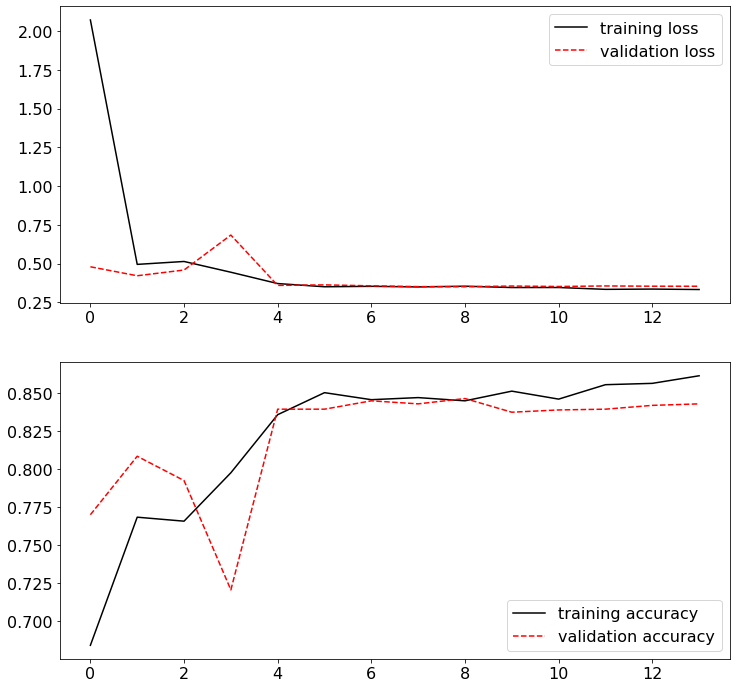

In [ ]:
hist2 = pd.DataFrame(history2.history)
fig, (ax1, ax2) = plt.subplots(figsize=(12,12),nrows=2, ncols=1)
hist2['loss'].plot(ax=ax1,c='k',label='training loss')
hist2['val_loss'].plot(ax=ax1,c='r',linestyle='--', label='validation loss')
ax1.legend()
hist2['acc'].plot(ax=ax2,c='k',label='training accuracy')
hist2['val_acc'].plot(ax=ax2,c='r',linestyle='--',label='validation accuracy')
ax2.legend()
plt.show()

## Comparison

We can see the first network did a better job in terms of reducing the optimization loss, maximizing the validation accuracy, and having fewer off-diagonal confusion matrix elements.
